In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Trigger Timing Test for Valeriia

Author: Andrew A Clark
Email: andrew.clark@uzh.ch

Version: 0.2

Date: 2023-02-14

UPDATE LOG:
    2021-02-14: 0.1 - Initial version
    2021-04-11: 0.2 - Fixed summery stats table so that units are correct.  Was displaying samples instead of ms.

"""
import matplotlib.pyplot as plt
import mne
import numpy as np
from rich import print
from rich.table import Table


In [46]:
def summary(x):
    """Return summary statistics of one-dimensional array x."""
    return (np.min(x), np.percentile(x, 25), np.mean(x), np.std(x), np.median(x),
            np.percentile(x, 75), np.max(x))


In [47]:
# %% Read in the Data
data_file = "scheuchzi_triggers1.bdf"
eeg_data = mne.io.read_raw_bdf(data_file, preload=True)

#events, event_ids = mne.events_from_annotations(eeg_data)
#mne.viz.plot_events(events[0], sfreq=eeg_data.info['sfreq'])
#events = events[0] # To drop the annotations...

events = mne.find_events(eeg_data)  
events[:, 2] &= (2**16 - 1)  
SR = eeg_data.info['sfreq']
# print(eeg_data.info)


Extracting EDF parameters from /Users/aac/Desktop/temp/Valeriia-TriggerTests/scheuchzi_triggers1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5425151  =      0.000 ...  2649.000 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
486 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 85 99]


In [48]:
# Finds the delay between the trigger and the first crossing of the threshold
# th sets the threshold
# test_window sets the window in which to search for the threshold crossing
# will only work for triggers for audio events (i.e. 1-80 I think)

th = 0.2    #Threshold
ergo_data = eeg_data.get_data('Erg1') # Get the data from the Erg1 channel which has the audio
ergo_data = ergo_data[0]
test_window = int(SR *2) # 2 seconds
delay = np.empty((0,2), order='C')

for trigger in events:
    if trigger[2] <=80:
        segment = ergo_data[trigger[0]:trigger[0]+test_window]
        mask = np.diff(1 * (segment > th) != 0)
        next_cross = [i for i, n in enumerate(mask) if n == True][0]
        delay = np.row_stack((delay, np.array([trigger[2], next_cross])))
    else:
        continue

In [49]:
# Sanity Check delay stats for all events
# As there are only two occurences of each trigger, it is not worth doing full stats for each trigger.
table = Table("", "min", "q25", "mean","STD", "median", "q75", "max", title="Difference (ms)")
table.add_row('Summary delay for all triggers mesured', *[f"{stat:.2f}" for stat in summary(delay[:,1]* 1000/SR)])
print(table)

                                              Difference (ms)                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃                                                 ┃ min   ┃ q25   ┃ mean  ┃ STD  ┃ median ┃ q75   ┃ max   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ Summary delay for all triggers mesured(samples) │ 14.65 │ 35.03 │ 38.93 │ 6.96 │ 39.31  │ 43.95 │ 56.15 │
└─────────────────────────────────────────────────┴───────┴───────┴───────┴──────┴────────┴───────┴───────┘

In [50]:
# Calculate average delay for each trigger in ms
# Write to csv

average_delays = np.empty((0,2),dtype=int, order='C')
for triggers in range(1,81):
    trig_delay = delay[delay[:,0]==triggers]
    ave = np.mean(trig_delay[:,1]) * 1000/SR # Convert to ms
    average_delays = np.row_stack((average_delays, np.array([triggers, ave])))

np.savetxt("trigger_delays.csv", average_delays, fmt='%i, %1.2f',delimiter=",", header="Trigger, Delay(ms)")

Text(0.5, 0, 'Samples')

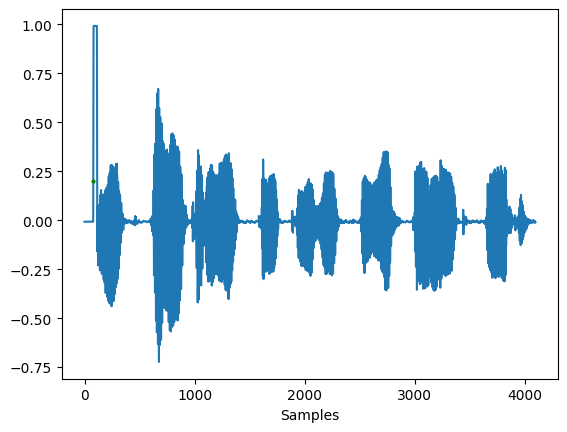

In [51]:
# to have a look at a specific event
# Change event_no to look at specific instance; searches for instances of a trigger number
event_no = np.where(events[:,2] == 1)
event_no = event_no[0][0] # To get the first instance of the trigger
segment = ergo_data[events[event_no,0]:events[event_no,0]+test_window]
mask = np.diff(1 * (segment > th) != 0)
next_cross = [i for i, n in enumerate(mask) if n == True][0]
plt.plot(segment)
plt.plot(next_cross, th, 'go', markersize=2)
plt.xlabel('Samples')

Text(0.5, 0, 'Time (s)')

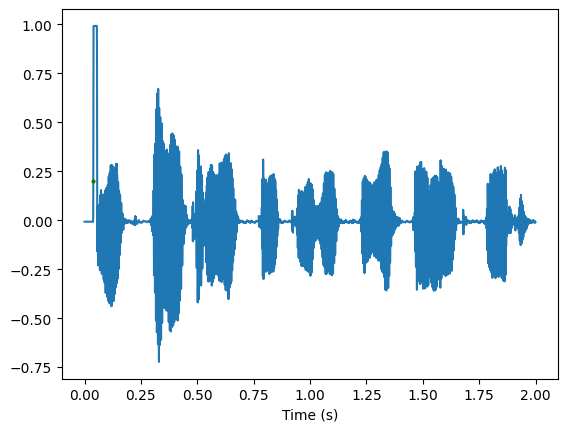

In [52]:
# Plot in time
segment_time = np.arange(len(segment))/SR
plt.plot(segment_time, segment)
plt.plot(next_cross * 1/SR, th, 'go', markersize=2)
plt.xlabel('Time (s)')